<a href="https://colab.research.google.com/github/dolmani38/drift/blob/main/Monitoring%20Data%20and%20Model%20Drift%20in%20your%20MLOps%20pipeline_%EC%88%98%EC%A0%952.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monitoring Data and Model Drift in your MLOps pipeline

https://www.persistent.com/blogs/monitoring-data-and-model-drift-in-your-mlops-pipeline/

https://docs.seldon.io/projects/alibi-detect/en/stable/index.html

In [1]:

if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/sj2503/drift-detection-project

Cloning into 'drift-detection-project'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 31 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.


# Installing and Importing Required Libraries:

In [3]:
!pip install mlflow
!pip install shap
!pip install evidently
!pip install alibi-detect

     |████████████████████████████████| 14.6 MB 252 kB/s 
     |████████████████████████████████| 1.1 MB 45.9 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 636 kB 52.4 MB/s 
     |████████████████████████████████| 170 kB 50.0 MB/s 
     |████████████████████████████████| 145 kB 55.4 MB/s 
     |████████████████████████████████| 79 kB 8.2 MB/s 
     |████████████████████████████████| 75 kB 4.4 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158172 sha256=9949ddf7797c0802e6b5db25d662369aa169c4e6b848be5a1a74e81dbd5e8c97
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for databricks-cli: filename=databricks_cli-0.15.0-py3-none-any.whl size=105260 sha256=5419f6a737d238b6fe9edf1d54140c4d465b756831319601a9620212540c4bf

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.feather_format import read_feather
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from evidently.dashboard import Dashboard
from evidently.tabs import ClassificationPerformanceTab, DataDriftTab

import mlflow
import shap
import sys
from alibi_detect.cd import ChiSquareDrift, KSDrift

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [6]:
%cd /content/drift-detection-project/Loan Prediction Model

/content/drift-detection-project/Loan Prediction Model


# Defining mlfow_run Function:

In [18]:
from alibi_detect.cd import KSDrift

print()
print("MLFlow run started...")
# get the dataset name
p_dataset = 'data.csv'
p_model = sys.argv[4] if len(sys.argv) > 4 else 'RandomForestClassifier'
print()
print("Loading dataset %s ..."%p_dataset)

# ##### LOAD THE DATA #####
data1 = pd.read_csv(p_dataset)
data1


MLFlow run started...

Loading dataset data.csv ...


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [35]:
categorical_data = data[categorical_columns].copy()
categorical_data["Gender"] = categorical_data["Gender"].map({"Male":1,"Female":0})
categorical_data["Married"] = categorical_data["Married"].map({"Yes":1,"No":0})
categorical_data["Dependents"] = categorical_data["Dependents"].map({"0":0,"1":1,"2":2,"3+":3})
categorical_data["Education"] = categorical_data["Education"].map({"Graduate":1, "Not Graduate":0})
categorical_data["Self_Employed"] = categorical_data["Self_Employed"].map({"Yes":1, "No":0})
categorical_data["Loan_Amount_Term"] = categorical_data["Loan_Amount_Term"].map({12:0,36:1,60:2,84:3,120:4,180:5,240:6,300:7,360:8,480:9})
categorical_data["Property_Area"] = categorical_data["Property_Area"].map({"Urban":2,"Semiurban":1, "Rural":0})

categorical_data

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Credit_History,Loan_Amount_Term
0,1.0,0.0,0.0,1,0.0,2,1.0,8.0
1,1.0,1.0,1.0,1,0.0,0,1.0,8.0
2,1.0,1.0,0.0,1,1.0,2,1.0,8.0
3,1.0,1.0,0.0,0,0.0,2,1.0,8.0
4,1.0,0.0,0.0,1,0.0,2,1.0,8.0
...,...,...,...,...,...,...,...,...
609,0.0,0.0,0.0,1,0.0,0,1.0,8.0
610,1.0,1.0,3.0,1,0.0,0,1.0,5.0
611,1.0,1.0,1.0,1,0.0,2,1.0,8.0
612,1.0,1.0,2.0,1,0.0,2,1.0,8.0


In [229]:

print("Pre-processing & Cleansing...")
data = data1.drop(columns=['Loan_ID']) ## Dropping Loan ID
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area','Credit_History','Loan_Amount_Term']
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount','Credit_History']
numerical_data = data[numerical_columns].copy()
categorical_data = data[categorical_columns].copy()
categorical_data["Gender"] = categorical_data["Gender"].map({"Male":1,"Female":0})
categorical_data["Married"] = categorical_data["Married"].map({"Yes":1,"No":0})
categorical_data["Dependents"] = categorical_data["Dependents"].map({"0":0,"1":1,"2":2,"3+":3})
categorical_data["Education"] = categorical_data["Education"].map({"Graduate":1, "Not Graduate":0})
categorical_data["Self_Employed"] = categorical_data["Self_Employed"].map({"Yes":1, "No":0})
categorical_data["Loan_Amount_Term"] = categorical_data["Loan_Amount_Term"].map({12:0,36:1,60:2,84:3,120:4,180:5,240:6,300:7,360:8,480:9})
categorical_data["Property_Area"] = categorical_data["Property_Area"].map({"Urban":2,"Semiurban":1, "Rural":0})
categorical_data = categorical_data.to_numpy().astype(int)


##### FEATURE ENGINEERING #####
print()
print("Feature Engineering...")
train_df_encoded = pd.get_dummies(data,drop_first=True)
X = train_df_encoded.drop(columns=['Loan_Status_Y'])
X_columns = X.columns
print(X_columns)
y = train_df_encoded['Loan_Status_Y']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.25)


Pre-processing & Cleansing...

Feature Engineering...
Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Gender_Male', 'Married_Yes',
       'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban'],
      dtype='object')


In [232]:

def model_build(X_train,X_test,y_train,y_test, explanations = True):
    imp = SimpleImputer(strategy='mean')
    imp_train = imp.fit(X_train)
    X_train = imp_train.transform(X_train)
    X_test_tmp = X_test.copy()
    X_test = imp_train.transform(X_test)
    X_test_df = pd.DataFrame(X_test, columns=X_columns)
    #imp_numerical_data = imp.fit(numerical_data)
    #numerical_data = imp_numerical_data.transform(numerical_data)
    # ##### BUILD ML MODEL #####
    print()
    print("Building the ML Model...")
    model = RandomForestClassifier(n_estimators=50,max_depth=5)
    model.fit(X_train,y_train)
    # print(list(zip(train_df_encoded.columns, model.feature_importances_)))       
    # cross-validation
    xval_scores = cross_val_score(model, X_train, y_train, cv=10)   

    # ##### METRICS #####
    print()
    print("Model evaluation...")
    y_pred = model.predict(X_train)
    train_f1 = f1_score(y_train,y_pred)
    train_acc = accuracy_score(y_train,y_pred)
    y_pred = model.predict(X_test)
    test_f1 = f1_score(y_test,y_pred)
    test_acc = accuracy_score(y_test,y_pred)
    print('--'*10)
    print('TRAINING ACCURACY', train_acc)
    print('TESTING ACCURACY', test_acc)
    print('--'*10)
    
    if explanations:
        # ##### EXPLANATIONS #####
        print()
        print("Generating explanations...")
        plt.figure(figsize=(30,15))
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test_tmp, show=False, class_names=['Rejected','Approved'])
        plt.savefig('SHAP_EXPLANATIONS.png', bbox_inches='tight')

    return X_train,X_test_df



Building the ML Model...

Model evaluation...
--------------------
TRAINING ACCURACY 0.8260869565217391
TESTING ACCURACY 0.7922077922077922
--------------------

Generating explanations...


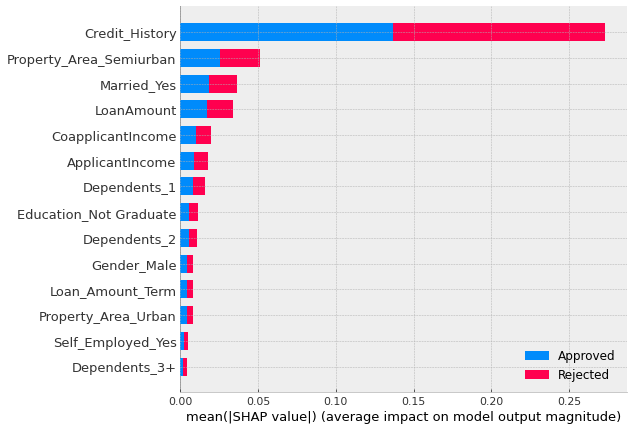

In [230]:

X_train,X_test_df = model_build(X_train,X_test,y_train,y_test)

 86/200 0.6541160153447174 1Trigger!!!

Building the ML Model...

Model evaluation...
--------------------
TRAINING ACCURACY 0.8173913043478261
TESTING ACCURACY 0.8181818181818182
--------------------

Generating explanations...
 86/200 0.6541160153447174 1Trigger!!!

Building the ML Model...

Model evaluation...
--------------------
TRAINING ACCURACY 0.8108695652173913
TESTING ACCURACY 0.7532467532467533
--------------------

Generating explanations...
 86/200 0.6541160153447174 1Trigger!!!

Building the ML Model...

Model evaluation...
--------------------
TRAINING ACCURACY 0.808695652173913
TESTING ACCURACY 0.7857142857142857
--------------------

Generating explanations...
 86/200 0.6541160153447174 1Trigger!!!
 202/200 0.36667859016921134 0

,model performance,ApplicantIncome KPI,ApplicantIncome Drift,ApplicantIncome p_val,CoapplicantIncome KPI,CoapplicantIncome Drift,CoapplicantIncome p_val,LoanAmount KPI,LoanAmount Drift,LoanAmount p_val,Loan_Amount_Term KPI,Loan_Amount_Term Drift,Loan_Amount_Term p_val,Credit_History KPI,Credit_History Drift,Credit_History p_val,Gender_Male KPI,Gender_Male Drift,Gender_Male p_val,Married_Yes KPI,Married_Yes Drift,Married_Yes p_val,Dependents_1 KPI,Dependents_1 Drift,Dependents_1 p_val,Dependents_2 KPI,Dependents_2 Drift,Dependents_2 p_val,Dependents_3+ KPI,Dependents_3+ Drift,Dependents_3+ p_val,Education_Not Graduate KPI,Education_Not Graduate Drift,Education_Not Graduate p_val,Self_Employed_Yes KPI,Self_Employed_Yes Drift,Self_Employed_Yes p_val,Property_Area_Semiurban KPI,Property_Area_Semiurban Drift,Property_Area_Semiurban p_val,Property_Area_Urban KPI,Property_Area_Urban Drift,Property_Area_Urban p_val
0,0.792208,0.072868,0,0.572531,0.107086,0,1.418018e-01,0.061858,0,0.769334,0.017420,0,1.000000e+00,0.044523,0,0.976191,0.020384,0,1.000000,0.041813,0,0.987684,0.003614,0,1.0,0.014455,0,1.000000,0.024195,0,1.000000,0.013947,0,1.000000,0.013580,0,1.000000,0.012479,0,1.000000,0.028910,0,0.999978
1,0.792208,0.072868,0,0.572531,0.107086,0,1.418018e-01,0.061858,0,0.769334,0.017420,0,1.000000e+00,0.044523,0,0.976191,0.020384,0,1.000000,0.041813,0,0.987684,0.003614,0,1.0,0.014455,0,1.000000,0.024195,0,1.000000,0.013947,0,1.000000,0.013580,0,1.000000,0.012479,0,1.000000,0.028910,0,0.999978
2,0.792208,0.072868,0,0.572531,0.107086,0,1.418018e-01,0.061858,0,0.769334,0.017420,0,1.000000e+00,0.044523,0,0.976191,0.020384,0,1.000000,0.041813,0,0.987684,0.003614,0,1.0,0.014455,0,1.000000,0.024195,0,1.000000,0.013947,0,1.000000,0.013580,0,1.000000,0.012479,0,1.000000,0.028910,0,0.999978
3,0.792208,0.072868,0,0.572531,0.107086,0,1.418018e-01,0.061858,0,0.769334,0.017420,0,1.000000e+00,0.044523,0,0.976191,0.020384,0,1.000000,0.041813,0,0.987684,0.003614,0,1.0,0.014455,0,1.000000,0.024195,0,1.000000,0.013947,0,1.000000,0.013580,0,1.000000,0.012479,0,1.000000,0.028910,0,0.999978
4,0.792208,0.073066,0,0.569024,0.107086,0,1.418018e-01,0.061858,0,0.769334,0.017420,0,1.000000e+00,0.044523,0,0.976191,0.020384,0,1.000000,0.041813,0,0.987684,0.003614,0,1.0,0.014455,0,1.000000,0.024195,0,1.000000,0.013947,0,1.000000,0.013580,0,1.000000,0.012479,0,1.000000,0.028910,0,0.999978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,0.389610,0.991304,1,0.000000,0.541304,1,8.660647e-30,1.000000,1,0.000000,0.415217,1,1.056191e-17,0.193845,1,0.000343,0.160785,1,0.005133,0.065161,0,0.711385,0.022812,0,1.0,0.031592,0,0.999836,0.090147,0,0.305552,0.082665,0,0.409613,0.029757,0,0.999955,0.034133,0,0.999294,0.046330,0,0.965435
452,0.422078,0.991304,1,0.000000,0.541304,1,8.660647e-30,1.000000,1,0.000000,0.415217,1,1.056191e-17,0.200339,1,0.000190,0.180265,1,0.001108,0.078148,0,0.481551,0.009825,0,1.0,0.057566,0,0.839115,0.083653,0,0.394748,0.134613,1,0.030556,0.029757,0,0.999955,0.047120,0,0.959888,0.020356,0,1.000000
453,0.422078,0.993478,1,0.000000,0.541304,1,8.660647e-30,1.000000,1,0.000000,0.415217,1,1.056191e-17,0.200339,1,0.000190,0.180265,1,0.001108,0.078148,0,0.481551,0.009825,0,1.0,0.057566,0,0.839115,0.083653,0,0.394748,0.134613,1,0.030556,0.029757,0,0.999955,0.047120,0,0.959888,0.020356,0,1.000000
454,0.422078,0.995652,1,0.000000,0.541304,1,8.660647e-30,1.000000,1,0.000000,0.415217,1,1.056191e-17,0.200339,1,0.000190,0.180265,1,0.001108,0.078148,0,0.481551,0.009825,0,1.0,0.057566,0,0.839115,0.083653,0,0.394748,0.134613,1,0.030556,0.029757,0,0.999955,0.047120,0,0.959888,0.020356,0,1.000000


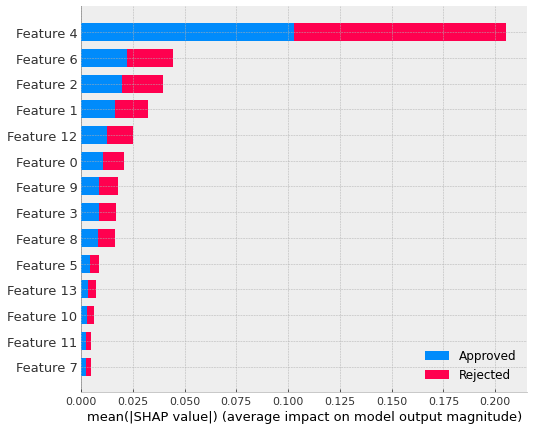

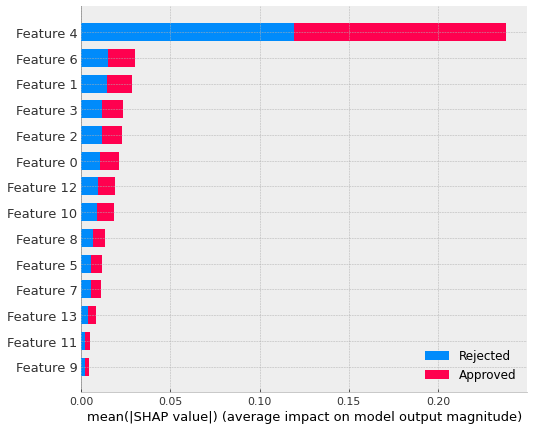

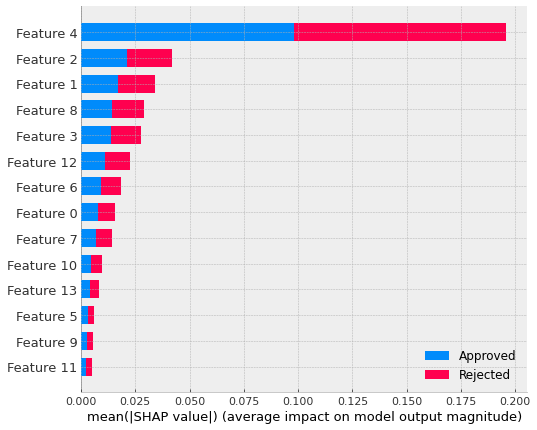

In [231]:
import random

result_data = {}
result_data['model performance'] = []
for column in X_columns:
    result_data[column + ' KPI'] = []
    result_data[column + ' Drift'] = []
    result_data[column + ' p_val'] = []


epochs = 200

epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
max_epsilon = 1 # You can't explore more than 100% of the time
min_epsilon = 0.001 # At a minimum, we'll always explore 1% of the time
decay = 1/epochs

Trigger = True
# data drift detect...
cd = KSDrift(X_train, p_val=0.05)
step = 0

retrain_limit = 3
retrain_count = 0
while True:
    if step > epochs:
        break
    step += 1
    RG = 200000/step
    # ##### DRIFT GENERATOR DATASET ######
    #print()
    #print("Creating dataset with data drift...")
    X_test_df_old = X_test_df.copy()
    random_number = np.random.rand()
    for i in range(0,X_test_df.shape[0]):
            ApplicantIncome_Change = np.random.randint(-60,-20)
            LoanAmount_Change = np.random.randint(30,71)
            CoapplicantIncome_Change = np.random.randint(-60,-20)
            X_test_df.loc[i,"ApplicantIncome"] = (1 + (ApplicantIncome_Change/RG)) * X_test_df.loc[i,"ApplicantIncome"]
            if(X_test_df.loc[i,"CoapplicantIncome"]!=0):
                    X_test_df.loc[i,"CoapplicantIncome"] = (1 + (CoapplicantIncome_Change/RG)) * X_test_df.loc[i,"CoapplicantIncome"]
            X_test_df.loc[i,"LoanAmount"] = (1 + (LoanAmount_Change/RG)) * X_test_df.loc[i,"LoanAmount"]
            '''
            categorical_data["Gender"] = categorical_data["Gender"].map({"Male":1,"Female":0})
            categorical_data["Married"] = categorical_data["Married"].map({"Yes":1,"No":0})
            categorical_data["Dependents"] = categorical_data["Dependents"].map({"0":0,"1":1,"2":2,"3+":3})
            categorical_data["Education"] = categorical_data["Education"].map({"Graduate":1, "Not Graduate":0})
            categorical_data["Self_Employed"] = categorical_data["Self_Employed"].map({"Yes":1, "No":0})
            categorical_data["Loan_Amount_Term"] = categorical_data["Loan_Amount_Term"].map({12:0,36:1,60:2,84:3,120:4,180:5,240:6,300:7,360:8,480:9})
            categorical_data["Property_Area"] = categorical_data["Property_Area"].map({"Urban":2,"Semiurban":1, "Rural":0})
            '''
            
            # 2. Explore using the Epsilon Greedy Exploration Strategy
            if random_number <= epsilon:
                pass
            else:
                # Explore
                if np.random.rand() < 0.01:
                    X_test_df.loc[i,"Credit_History"] = 1 - X_test_df.loc[i,"Credit_History"]                
                if random.choice([0,1]):
                    X_test_df.loc[i,"Gender_Male"] = 1 - X_test_df.loc[i,"Gender_Male"]
                if random.choice([0,1]):    
                    X_test_df.loc[i,"Married_Yes"] = 1 - X_test_df.loc[i,"Married_Yes"]
                if random.choice([0,1]):
                    c = random.choice([0,1,2,3])
                    X_test_df.loc[i,"Dependents_1"] = (1 if c == 1 else 0)
                    X_test_df.loc[i,"Dependents_2"] = (1 if c == 2 else 0)
                    X_test_df.loc[i,"Dependents_3+"] = (1 if c == 3 else 0)
                if random.choice([0,1]):
                    X_test_df.loc[i,"Education_Not Graduate"] = 1 - X_test_df.loc[i,"Education_Not Graduate"]
                X_test_df.loc[i,"Loan_Amount_Term"] = random.choice([0,1,2,3,4,5,6,7,8,9])
                if random.choice([0,1]):
                    c = random.choice([2,1,0])
                    X_test_df.loc[i,"Property_Area_Semiurban"] = (1 if c == 1 else 0)
                    X_test_df.loc[i,"Property_Area_Urban"] = (1 if c == 2 else 0)


    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * step)

    preds = cd.predict(X_test_df[X_columns].to_numpy(), drift_type='batch', return_p_val=True, return_distance=True)
    fpreds = cd.predict(X_test_df[X_columns].to_numpy(), drift_type='feature')
    for f in range(cd.n_features):
        stat = 'K-S'
        fname = X_columns[f]
        is_drift = fpreds['data']['is_drift'][f]
        stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
        #print(f'{fname}-- Drift? {[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.5f}') 
        result_data[fname + ' KPI'].append(stat_val)
        result_data[fname + ' Drift'].append(is_drift)
        result_data[fname + ' p_val'].append(p_val)

    y_pred_datadrift = model.predict(X_test_df)
    datadrift_test_acc = accuracy_score(y_test,y_pred_datadrift)
    #print("Datadrift_Test_Accuracy: ",datadrift_test_acc)
    result_data['model performance'].append(datadrift_test_acc)

    print(f"\r {step+1}/{epochs} {epsilon} {result_data['Credit_History Drift'][step-1]}", end="", flush=True)

    if Trigger and result_data['Credit_History Drift'][step-1] == 1 and result_data['ApplicantIncome Drift'][step-1] == 1 and result_data['CoapplicantIncome Drift'][step-1] == 1 and result_data['LoanAmount Drift'][step-1] == 1:
        print('Trigger!!!')
        Trigger = False
        if retrain_count < retrain_limit and True:
            X = np.concatenate([X_train,X_test_df.to_numpy()])
            y = np.concatenate([y_train,y_test])
            X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.25)
            X_train,X_test_df = model_build(X_train,X_test,y_train,y_test,explanations=False)
            cd = KSDrift(X_train, p_val=0.05)
            step = 0
            epsilon = 1
            retrain_count += 1
            Trigger = True





result_df = pd.DataFrame(result_data)

#result_df.plot()
result_df

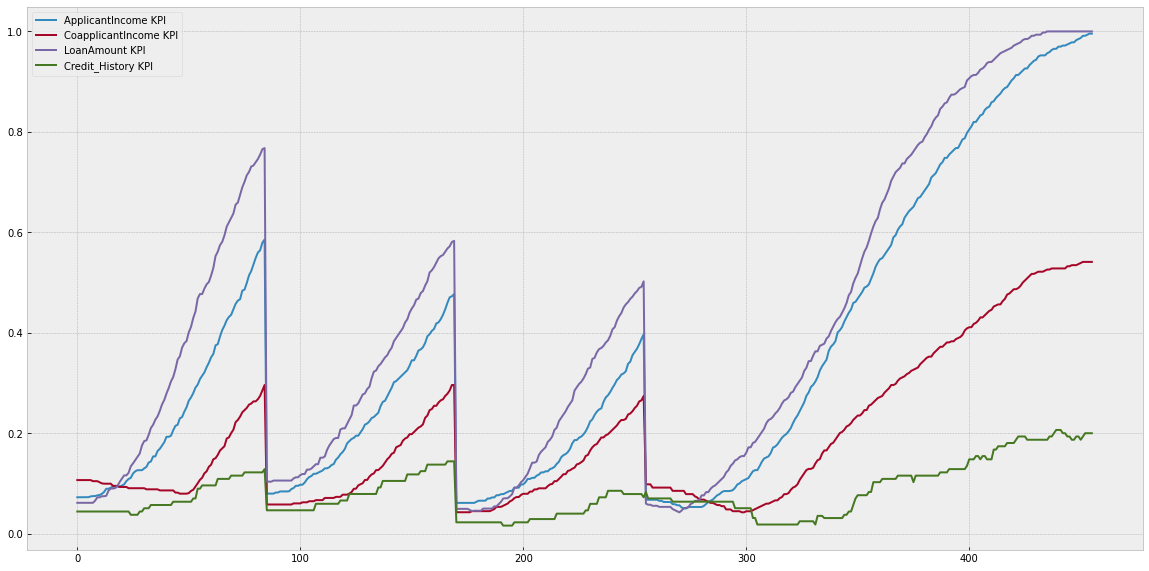

In [233]:
# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')
result_df[['ApplicantIncome KPI','CoapplicantIncome KPI','LoanAmount KPI','Credit_History KPI']].plot(figsize=(20,10))

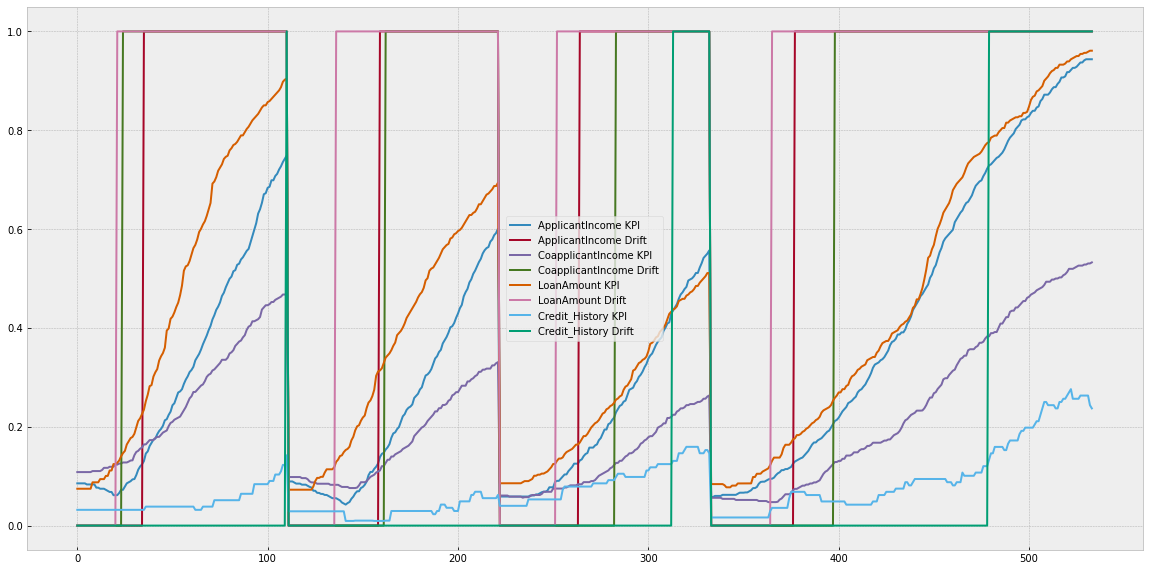

In [222]:
result_df[['ApplicantIncome KPI','ApplicantIncome Drift','CoapplicantIncome KPI','CoapplicantIncome Drift','LoanAmount KPI','LoanAmount Drift','Credit_History KPI','Credit_History Drift']].plot(figsize=(20,10))

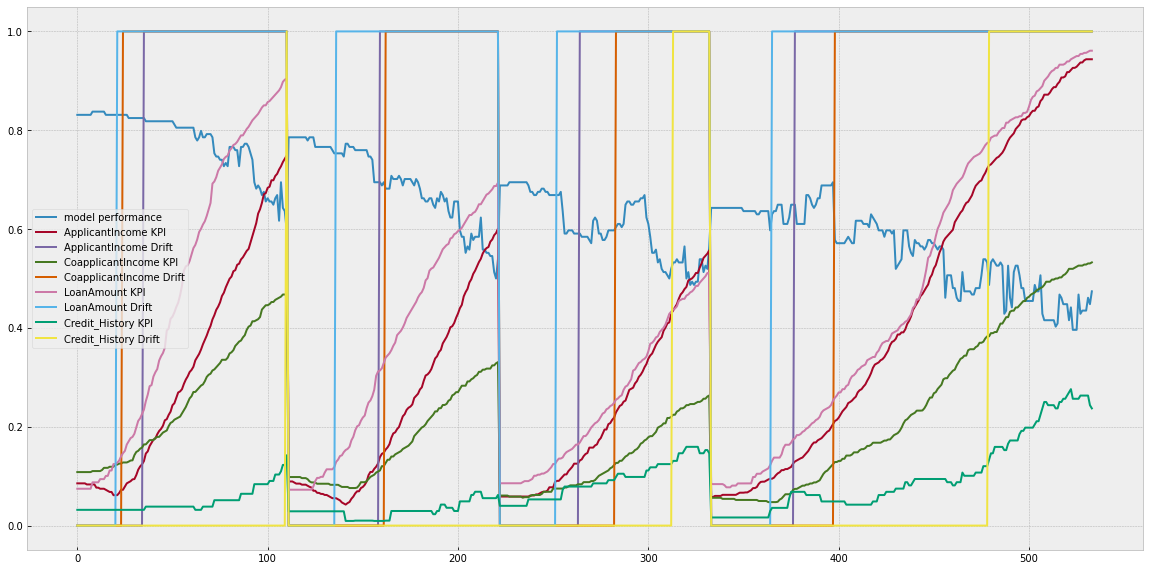

In [223]:

result_df[['model performance','ApplicantIncome KPI','ApplicantIncome Drift','CoapplicantIncome KPI','CoapplicantIncome Drift','LoanAmount KPI','LoanAmount Drift','Credit_History KPI','Credit_History Drift']].plot(figsize=(20,10))

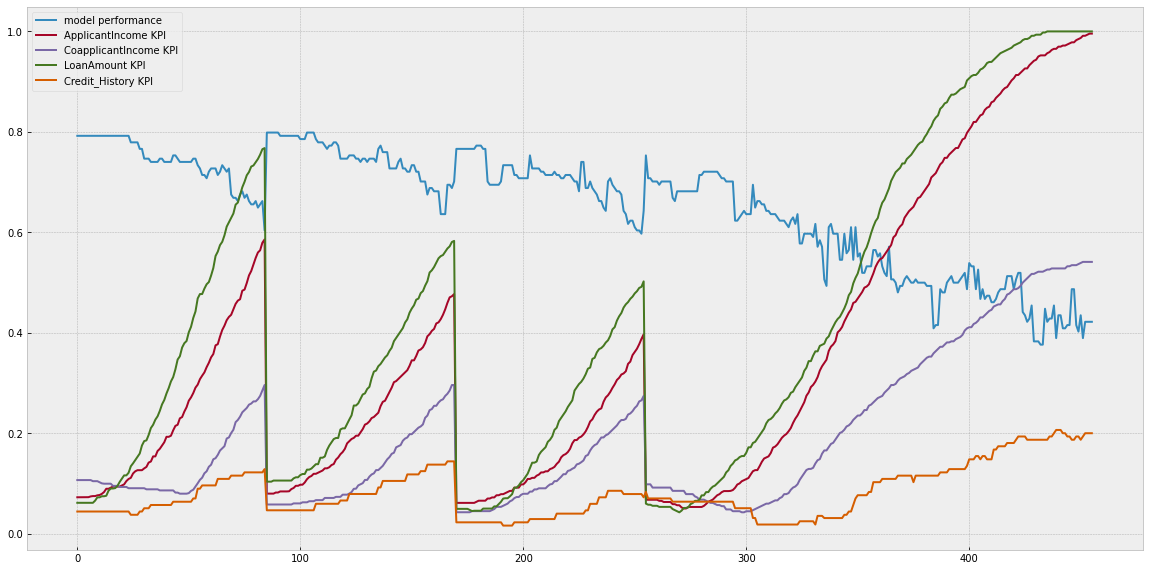

In [234]:

result_df[['model performance','ApplicantIncome KPI','CoapplicantIncome KPI','LoanAmount KPI','Credit_History KPI']].plot(figsize=(20,10))

# Defining Function to Assign Ground Truth Values to Concept Drift Input Data

In [ ]:
def GroundTruthValue(ApplicantIncome, LoanAmount, ApplicantIncome_Change, LoanAmount_Change):
        if(ApplicantIncome>10000 and LoanAmount <=1000):
                return 1
        elif(ApplicantIncome<2500 and LoanAmount >=250):
                return 0
        elif(ApplicantIncome>=7500 and ApplicantIncome_Change > -10 and LoanAmount_Change < 45 and LoanAmount<400):
                return 1
        elif(ApplicantIncome<5000 and ApplicantIncome_Change < -5 and LoanAmount_Change > 35 and LoanAmount > 250):
                return 0
        elif(ApplicantIncome_Change > 0 and LoanAmount_Change < 30 and ApplicantIncome > 5000):
                return 1
        elif(ApplicantIncome_Change < -5 and LoanAmount_Change > 25 and ApplicantIncome < 3500):
                return 0
        else:
                return 1

# Defining Function for New Input Data:

In [ ]:
def newinputdata(filename, input_dataframe, numerical_data, categorical_data):
    f =open(filename,"r")
    data = json.loads(f.read())
    newdataframe = pd.DataFrame.from_dict([data])
    input_dataframe = pd.concat([input_dataframe,newdataframe], axis=0, ignore_index=True)
    if(input_dataframe.shape[0]>=30):
        datadriftdetection(input_dataframe, numerical_data, categorical_data)
    return input_dataframe

# Defining Data Drift Detection Function:

In [ ]:
def datadriftdetection(input_dataframe, X_ref, categorical_data):
    print()
    print("Checking for Data Drift...")
    print()
    print("Numerical Data...")
    print()
    numeric_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
    numerical_input_dataframe = input_dataframe[numeric_columns].copy()
    numerical_input_dataframe_numpy = numerical_input_dataframe.to_numpy()
    categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area','Credit_History','Loan_Amount_Term']
    categorical_input_dataframe = input_dataframe[categorical_columns].copy()
    categorical_input_dataframe["Gender"] = categorical_input_dataframe["Gender"].map({"Male":1,"Female":0})
    categorical_input_dataframe["Married"] = categorical_input_dataframe["Married"].map({"Yes":1,"No":0})
    categorical_input_dataframe["Dependents"] = categorical_input_dataframe["Dependents"].map({"0":0,"1":1,"2":2,"3+":3})
    categorical_input_dataframe["Education"] = categorical_input_dataframe["Education"].map({"Graduate":1, "Not Graduate":0})
    categorical_input_dataframe["Self_Employed"] = categorical_input_dataframe["Self_Employed"].map({"Yes":1, "No":0})
    categorical_input_dataframe["Loan_Amount_Term"] = categorical_input_dataframe["Loan_Amount_Term"].map({12:0,36:1,60:2,84:3,120:4,180:5,240:6,300:7,360:8,480:9})
    categorical_input_dataframe["Property_Area"] = categorical_input_dataframe["Property_Area"].map({"Urban":2,"Semiurban":1, "Rural":0})
    categorical_input_dataframe_numpy = categorical_input_dataframe.to_numpy().astype(int)
    cd = KSDrift(X_ref, p_val=.05)
    preds = cd.predict(numerical_input_dataframe_numpy, drift_type='feature', return_p_val=True, return_distance=True)
    fpreds = cd.predict(numerical_input_dataframe_numpy, drift_type='feature')
    print(preds)
    print()
    for f in range(cd.n_features):
        stat = 'K-S'
        fname = numeric_columns[f]
        is_drift = fpreds['data']['is_drift'][f]
        stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
        print(f'{fname}-- Drift? {[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.5f}')   

    print()
    print("Categorical Data")
    print()
    cd = ChiSquareDrift(categorical_data, p_val=.05)
    preds = cd.predict(categorical_input_dataframe_numpy)
    print(preds)
    print()
    print(f"Threshold {preds['data']['threshold']}")
    stat = "Chi2"
    print()
    for f in range(cd.n_features):
        fname = categorical_columns[f]
        is_drift = (preds['data']['p_val'][f] < preds['data']['threshold']).astype(int)
        stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
        print(f'{fname} -- Drift? {[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')

# Starting the mlflow_run Function:

In [ ]:
%cd /content/drift-detection-project/Loan Prediction Model
create_mlflow_run()

/content/drift-detection-project/Loan Prediction Model

MLFlow run started...

Loading dataset data.csv ...

Pre-processing & Cleansing...

Feature Engineering...


KeyError: ignored